In [1]:
%%capture
!pip install pandas
!pip install ruptures
!pip install numpy
!pip install matplotlib

!pip install saxpy
!pip install tsfresh
!pip install seaborn
!pip install sklearn
!pip3 install -U scikit-learn scipy matplotlib




# basic packages
import pandas as pd
import numpy as np
import datetime as dt
from pytz import timezone
import urllib
import os
import math
from scipy import stats
from scipy.signal import find_peaks, spectrogram

# packages for visualizations
import matplotlib.dates as mdates

from matplotlib import pyplot as plt

# package for feature training

# sklearn packages
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans


from sklearn.impute import SimpleImputer

%matplotlib inline



In [2]:
alldata = pd.read_csv("./CC_LCL-FullData_without_stdorToU.csv")
print('A sample of household IDs:', alldata.LCLid.unique()[:10])
household = "MAC000002"


df = alldata[alldata["LCLid"] == household ]
df.reset_index(drop=True, inplace=True)
import calendar


A sample of household IDs: ['MAC000002' 'MAC000003' 'MAC000004' 'MAC000006' 'MAC000007' 'MAC000008'
 'MAC000009' 'MAC000010' 'MAC000011' 'MAC000012']


In [3]:
import calendar

# Convert 'DateTime' column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Assuming 'DateTime' is now a datetime column
df.loc[:, 'weekday'] = df['DateTime'].dt.day_name()

# Order the weekdays correctly
df.loc[:, 'weekday'] = pd.Categorical(df['weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Assuming 'DateTime' is now a datetime column
df.loc[:, 'month'] = df['DateTime'].dt.month_name()

# Order the months correctly
df.loc[:, 'month'] = pd.Categorical(df['month'], categories=calendar.month_name[1:], ordered=True)



/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_11472/1563538492.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = pd.to_datetime(df['DateTime'])
/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_11472/1563538492.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'weekday'] = df['DateTime'].dt.day_name()
/var/folders/s4/22x3mwpj4bldz0pl87jpf5th0000gn/T/ipykernel_11472/1563538492.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [4]:
print('Earliest date:', df['DateTime'].min())
print('Latest date:', df['DateTime'].max())


Earliest date: 2012-10-12 00:30:00
Latest date: 2014-02-28 00:00:00


In [5]:
# set energy consumption data to numeric type
df = df[df["KWH/hh (per half hour) "] != "Null"]
df.loc[:,"energy"] = df["KWH/hh (per half hour) "].astype("float64")

# calculate the cumulative energy use over time for each date
df.loc[:,"cumulative_sum"] = df.groupby('DateTime')["energy"].cumsum()
df = df.set_index("DateTime")
df.head()

,LCLid,KWH/hh (per half hour),weekday,month,energy,cumulative_sum
DateTime,,,,,,
2012-10-12 00:30:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 01:00:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 01:30:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 02:00:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 02:30:00,MAC000002,0,Friday,October,0.0,0.0


<Axes: xlabel='DateTime'>

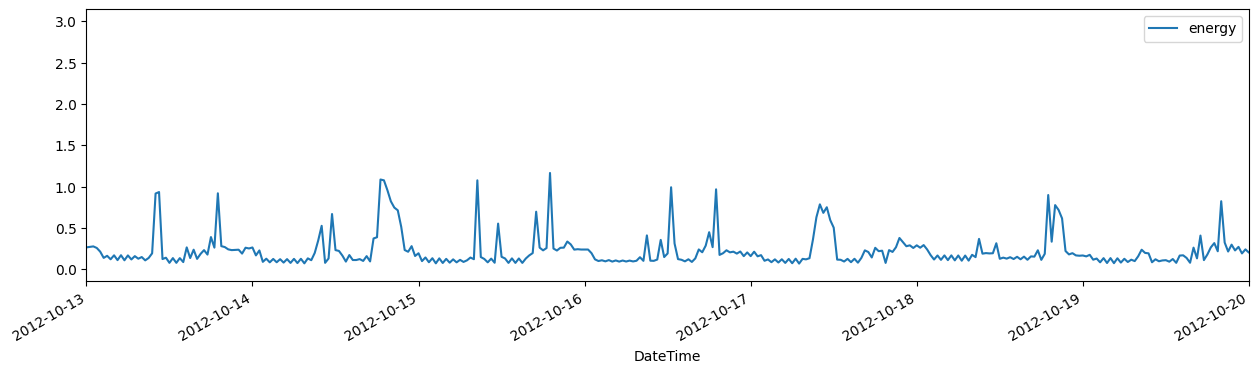

In [6]:
df.plot(y="energy", figsize=(15, 4), xlim=('2012-10-13', '2012-10-20'))


In [7]:
train_size = int(0.8 * len(df))
X_train, X_test = df[:train_size].index, df[train_size:].index
y_train, y_test = df[:train_size]["energy"].values, df[train_size:]["energy"].values

train_data = pd.concat([pd.Series(X_train), pd.Series(y_train)], axis=1, keys=["ds", "y"])
test_data = pd.concat([pd.Series(X_test), pd.Series([0]*len(y_test))], axis=1, keys=["ds", "y"])
answer_data = pd.concat([pd.Series(X_test), pd.Series(y_test)], axis=1, keys=["ds", "y"])

In [11]:
from prophet import Prophet
from prophet.plot import plot_seasonality , plot_weekly, plot_yearly

train_data = pd.concat([pd.Series(X_train), pd.Series(y_train)], axis=1, keys=["ds", "y"])


model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(train_data)

16:13:03 - cmdstanpy - INFO - Chain [1] start processing
16:13:05 - cmdstanpy - INFO - Chain [1] done processing


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],


TypeError: agg function failed [how->mean,dtype->object]

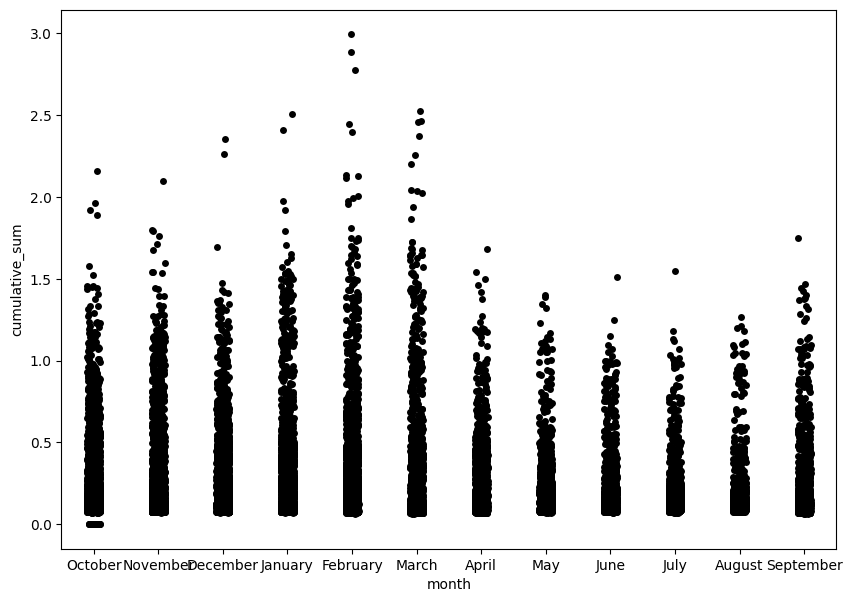

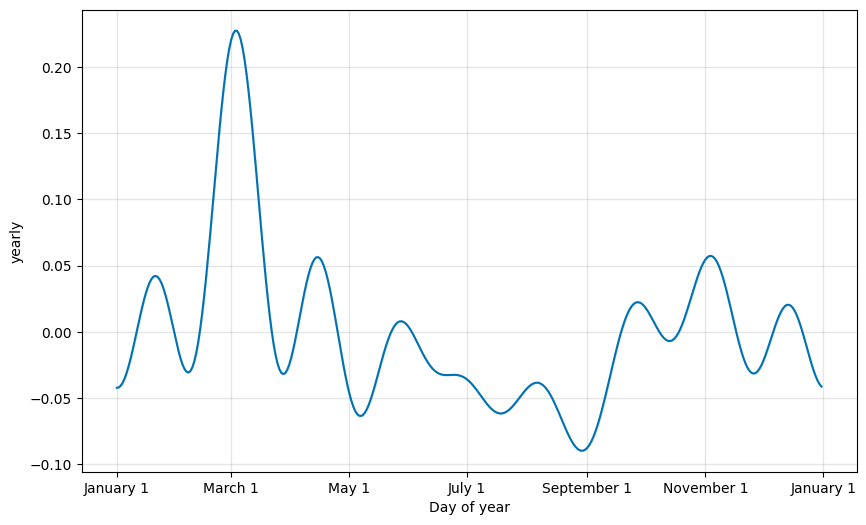

In [12]:
import seaborn as sns

fig, axs = plt.subplots(figsize=(10,7))
sns.stripplot(x='month', y='cumulative_sum', data=df, color='black')

fig = plot_yearly(model)

df.groupby('month').mean()


In [16]:
df.head()

,LCLid,KWH/hh (per half hour),weekday,month,energy,cumulative_sum
DateTime,,,,,,
2012-10-12 00:30:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 01:00:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 01:30:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 02:00:00,MAC000002,0,Friday,October,0.0,0.0
2012-10-12 02:30:00,MAC000002,0,Friday,October,0.0,0.0


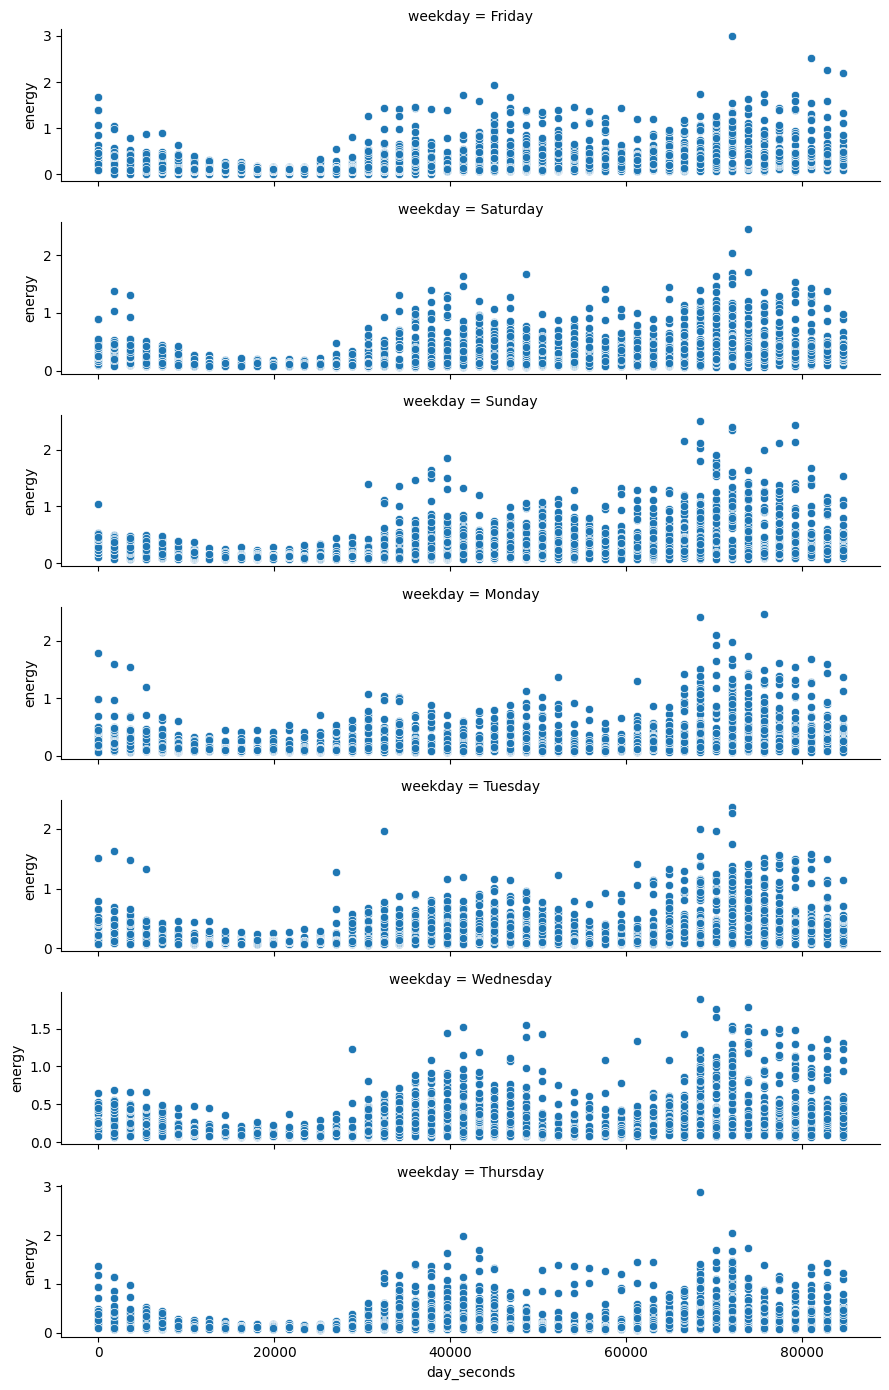

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
df.reset_index(inplace=True)

# Assuming 'day_seconds' is not present, create it from 'DateTime'
df['day_seconds'] = df['DateTime'].dt.hour * 3600 + df['DateTime'].dt.minute * 60 + df['DateTime'].dt.second

# Now, create the FacetGrid
g = sns.FacetGrid(df, row="weekday", aspect=4.5, height=2, sharey=False)
g.map(sns.scatterplot, 'day_seconds', 'energy')
plt.show()